In [1]:
! pip install gensvm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensvm: filename=gensvm-0.2.7-cp310-cp310-linux_x86_64.whl size=347661 sha256=38225fe69f2ce7a35d92e248005c2a0413ba4becbc6ef482d1a0b6a6b3330a4a
  Stored in directory: /root/.cache/pip/wheels/0f/d5/a8/73572f13bd63eb5b1765afe06e570a22bd4d4c8892cd305e97
Successfully built gensvm


In [2]:
!pip install scikit-learn==1.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 35.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.8.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from gensvm import GenSVM
import seaborn as sns

%matplotlib inline

## Loading input data

In [17]:
from sklearn.datasets import load_iris, make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [18]:
# Load the Iris dataset
iris = load_iris()

# Select only two classes (classes 1 and 2) and encode labels
Xtrain = iris.data
Ttrain = iris.target

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(Xtrain, Ttrain, test_size=0.1, random_state=54, shuffle=True)

# Normalizaing the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Train and test model

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
# Define parameter grid for Grid Search
param_grid = {
    'p': [1,2],
    'kappa' : [0,1,5,10],
    'coef':[0.1,1,10,100]
}

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(GenSVM(), param_grid, cv=10)
grid_search.fit(x_train, y_train)


In [26]:
# Print best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.2f}" )
model = grid_search.best_estimator_
accuracy = model.score(x_test,y_test)
print(f'Accuracy of best parameters on Test data: {accuracy*100:.2f}')

Best parameters found: {'coef': 10, 'kappa': 1, 'p': 2}
Best cross-validation score: 0.99
Accuracy of best parameters on Test data: 100.00


In [31]:
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
y_hat= model.predict(x_test)
cm = confusion_matrix(y_test, y_hat)
cm = cm/np.sum(cm, axis=1).reshape(-1,1)
print('Classification report for Test data:\n',classification_report(y_test, y_hat, target_names=iris.target_names))

Classification report for Test data:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         5
  versicolor       1.00      1.00      1.00         5
   virginica       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



Text(0.5, 1.0, 'Confusion Matrix for Test data')

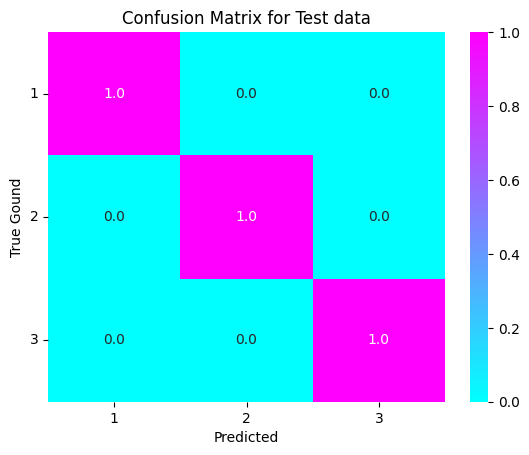

In [46]:
# Plotting confusion matrix
sns.heatmap(cm, annot=True, cmap='cool', fmt='.1f');
plt.xticks(np.array(range(0,3)).astype('float32')+0.5, range(1,4));
plt.yticks(np.array(range(0,3)).astype('float32')+0.5, range(1,4), rotation=0);
plt.xlabel('Predicted')
plt.ylabel('True Gound')
plt.title('Confusion Matrix for Test data')

## useless

In [ ]:
# x_train.shape

(800, 3)

In [ ]:
def l_msvm(y, n, H, W, lmd=0.0001 , ro=1, **kwarg):

    loss_main = 0
    c_idx,clses = find_class(y)
    for i in range(k):

        Hh = H[:,:,c_idx[i]]
        for j in range(Hh.shape[2]):

            h = 0
            for l in range(k):

                if l != i:
                    h +=  Hh[i,l,0,j]**p
            h = h**(1/p)
        h = ro*h
        loss_main += h
    loss_reg = np.trace(np.dot(W.T,W))*lmd
    loss_total = loss_main + loss_reg
    return loss_total


def find_class(label):

    unique = np.unique(label)
    idxs = []
    for i,u in enumerate(unique):

        idx = np.where(label==u)
        idxs.append(idx)
    return idxs, unique



def compute_ab(x_bar,p,k):

    c = (p+k-1)/(p-2)
    k12 = (k+1)/2
    xbark12 = 1 - x_bar - k12
    f19 = 1/4 * p * (2*p-1) * k12**(p-2)
    f22 = 1/4 * p**2 * xbark12**(p-2)
    f23 = 1/4 * p**2 * (p/(p-2) * xbark12)**(p-2)
    if x_bar>1 and p == 2:
        a = f19
        b = a*x_bar
    elif x_bar>1 and p != 2:
        a = f23
        b = a * ((p*x_bar+k-1)/(p-2)) + 1/2 * p *(p/(p-2)*(xbark12))**(p-1)
    elif x_bar > -k and x_bar<= 1:
        a = f19
        b = a*x_bar + p/(1-x_bar) * ((1-x_bar)/np.sqrt(2*(k+1)))**(2*p)
    elif x_bar > c and x_bar <= k:
        a = f19
        b = a*x_bar + 1/2 * p * (xbark12)**(p-1)
    elif x_bar <= c:
        a = f22
        b = a*x_bar + 1/2 * p * (xbark12)**(p-1)
    return a,b



In [28]:
# X = x_train
# y = y_train
# kappa = 5
# p = 2
# ro = 1 # CORRECT THIS PAGE 8 OF THE ARTICLE
# lmd = 0.1
# eps = 0.001

# # Initialization
# np.random.seed(54)
# m = X.shape[1] # Number of features
# k = len(np.unique(y)) # Number of classes
# n = X.shape[0] # Number of samples
# W = np.random.rand(m,k-1)
# K = y
# t = 1
# Z = np.hstack((np.ones(shape=(X.shape[0],1)), X))
# T = np.random.rand(W.shape[1],1)
# V_0 = np.hstack((T,W.T)).T
# V_bar = V_0.copy()
# V = V_bar.copy()
# J = np.identity(m+1)
# J[0,0] = 0
# Uk = np.zeros(shape=(k, k-1))
# for i in range(k):

#     for j in range(k-1):

#         if i <= j:
#             Uk[i, j] = -np.sqrt(1 / np.sqrt(2*(j**2+1)))
#         if i == j + 1:
#             Uk[i, j] = np.sqrt(1 / np.sqrt(2*(j**2+1)))

# S = np.dot(X,W) + T.T
# delta = np.zeros(shape=(k-1,k-1,n))
# Q = np.zeros(shape=(k,k,n))
# H = np.zeros(shape=(k,k,n))
# for s in range(n):

#     for i in range(k):

#         uu = 0
#         for j in range(k):

#            if i != j:

#                 u = Uk[i,:] - Uk[j,:]
#                 delta[uu,:,s] = u
#                 uu += 1
#                 ss = S[s,:]
#                 projection = np.dot(ss, u) / np.dot(u, u) * u
#                 perpendicular = ss - projection
#                 Q[i,j,s] = np.linalg.norm(perpendicular)
#                 if Q[i,j,s] <= -kappa:
#                     H[i,j,s] = 1 - Q[i,j,s] - (kappa+1)/2
#                 elif Q[i,j,s] > -kappa and Q[i,j,s] <= 1:
#                     H[i,j,s] = 1/(2*(kappa+1)) * (1-Q[i,j,s]**2)
# HH = H.copy()
# L_t = l_msvm(y,n,H,W,k=k,p=p)
# L_t1 = (1+2*eps) * L_t
# while (L_t1 - L_t)/L_t > eps:
# # for _ in range(3):

#     A = np.zeros(shape=(n,n))
#     B = np.zeros(shape=(n,k-1))
#     H_bar = np.zeros_like(H)
#     for i in range(n):
#         q_bar = Z[i,:].dot(V_bar).dot(delta[:,:,i])
#         h_bar = np.zeros_like(q_bar)
#         for ii in range(len(q_bar)):

#             if q_bar[ii] <= -kappa:
#                 h_bar[ii] = 1 - q_bar[ii] - (kappa+1)/2
#             elif q_bar[ii] > -kappa and q_bar[ii] <= 1:
#                 h_bar[ii] = 1/(2*(kappa+1)) * (1-q_bar[ii]**2)
#         ep = 1 if sum(h_bar != 0) <=1 else 0
#         x_bar = np.mean(Z[i,:])
#         a = np.zeros_like(h_bar)
#         b = np.zeros_like(h_bar)
#         if ep == 1:
#             for iii,x_bar in enumerate(h_bar):
#                 a_i,b_i = compute_ab(x_bar,p=1,k=kappa)
#                 a[iii] = a_i
#                 b[iii] = b_i
#         else:

#             omega = 1/p * np.sum(h_bar**p)**(1/(p-1))
#             for iii,x_bar in enumerate(h_bar):
#                 a_i,b_i = compute_ab(x_bar,p=1,k=kappa)
#                 a[iii] = a_i
#                 b[iii] = b_i
#         alpha = 1/n*ro*np.sum(ep*(a) + (1-ep)*omega*a)
#         beta = 1/n*ro*(ep*(b-a*q_bar) + (1-ep)*omega*(b-a*q_bar)).dot(delta[:,:,i].T)
#         A[i,i] = alpha
#         B[i,:] = beta

#     M_l = Z.T.dot(A).dot(Z) + lmd*J
#     M_r = Z.T.dot(A).dot(Z).dot(V_bar) + Z.T.dot(B)
#     V_new = solve(M_l,M_r)
#     V_bar = V.copy()
#     V = V_new.copy()
#     W = V_new[1:,:].copy().T
#     W = W.T
#     L_t1 = L_t
#     L_t = l_msvm(y,n,H,W,k=k,p=p)
#     t = t+1






In [29]:
# X = x_train
# y = y_train
# kappa = 5
# p = 2
# ro = 1 # CORRECT THIS PAGE 8 OF THE ARTICLE
# lmd = 0.1
# eps = 0.001

# # Initialization
# np.random.seed(54)
# m = X.shape[1] # Number of features
# k = len(np.unique(y)) # Number of classes
# n = X.shape[0] # Number of samples
# W = np.random.rand(m,k-1)
# K = y
# t = 1
# Z = np.hstack((np.ones(shape=(X.shape[0],1)), X))
# Z = Z.T
# T = np.random.rand(1,W.shape[1])
# V_0 = np.vstack((T,W))
# V_bar = V_0.copy()
# V = V_bar.copy()
# J = np.identity(m+1)
# J[0,0] = 0
# Uk = np.zeros(shape=(k, k-1))
# for i in range(k):

#     for j in range(k-1):

#         if i <= j:
#             Uk[i, j] = -np.sqrt(1 / np.sqrt(2*(j**2+1)))
#         if i == j + 1:
#             Uk[i, j] = np.sqrt(1 / np.sqrt(2*(j**2+1)))

# S = np.dot(X,W) + T.T
# delta = np.zeros(shape=(k-1,k-1,n))
# Q = np.zeros(shape=(k,k,n))
# H = np.zeros(shape=(k,k,n))
# for s in range(n):

#     for i in range(k):

#         uu = 0
#         for j in range(k):

#            if i != j:

#                 u = Uk[i,:] - Uk[j,:]
#                 delta[uu,:,s] = u
#                 uu += 1
#                 ss = S[s,:]
#                 projection = np.dot(ss, u) / np.dot(u, u) * u
#                 perpendicular = ss - projection
#                 Q[i,j,s] = np.linalg.norm(perpendicular)
#                 if Q[i,j,s] <= -kappa:
#                     H[i,j,s] = 1 - Q[i,j,s] - (kappa+1)/2
#                 elif Q[i,j,s] > -kappa and Q[i,j,s] <= 1:
#                     H[i,j,s] = 1/(2*(kappa+1)) * (1-Q[i,j,s]**2)
# HH = H.copy()
# L_t = l_msvm(y,n,H,W,k=k,p=p)
# L_t1 = (1+2*eps) * L_t
# while (L_t1 - L_t)/L_t > eps:
# # for _ in range(3):

#     A = np.zeros(shape=(n,n))
#     B = np.zeros(shape=(n,k-1))
#     H_bar = np.zeros_like(H)
#     for i in range(n):
#         q_bar = Z[i,:].dot(V_bar).dot(delta[:,:,i])
#         h_bar = np.zeros_like(q_bar)
#         for ii in range(len(q_bar)):

#             if q_bar[ii] <= -kappa:
#                 h_bar[ii] = 1 - q_bar[ii] - (kappa+1)/2
#             elif q_bar[ii] > -kappa and q_bar[ii] <= 1:
#                 h_bar[ii] = 1/(2*(kappa+1)) * (1-q_bar[ii]**2)
#         ep = 1 if sum(h_bar != 0) <=1 else 0
#         x_bar = np.mean(Z[i,:])
#         a = np.zeros_like(h_bar)
#         b = np.zeros_like(h_bar)
#         if ep == 1:
#             for iii,x_bar in enumerate(h_bar):
#                 a_i,b_i = compute_ab(x_bar,p=1,k=kappa)
#                 a[iii] = a_i
#                 b[iii] = b_i
#         else:

#             omega = 1/p * np.sum(h_bar**p)**(1/(p-1))
#             for iii,x_bar in enumerate(h_bar):
#                 a_i,b_i = compute_ab(x_bar,p=1,k=kappa)
#                 a[iii] = a_i
#                 b[iii] = b_i
#         alpha = 1/n*ro*np.sum(ep*(a) + (1-ep)*omega*a)
#         beta = 1/n*ro*(ep*(b-a*q_bar) + (1-ep)*omega*(b-a*q_bar)).dot(delta[:,:,i].T)
#         A[i,i] = alpha
#         B[i,:] = beta

#     M_l = Z.T.dot(A).dot(Z) + lmd*J
#     M_r = Z.T.dot(A).dot(Z).dot(V_bar) + Z.T.dot(B)
#     V_new = solve(M_l,M_r)
#     V_bar = V.copy()
#     V = V_new.copy()
#     W = V_new[1:,:].copy().T
#     W = W.T
#     L_t1 = L_t
#     L_t = l_msvm(y,n,H,W,k=k,p=p)
#     t = t+1






In [ ]:
# new = Z.dot(V)

In [ ]:
# print((800,3))
# print((800,2))
# print('4 classes,  2 features')

# print(new.shape)
# print(x_train.shape)
# print('3 classes, 2 features')

(800, 3)
(800, 2)
4 classes,  2 features
(120, 2)
(120, 2)
3 classes, 2 features


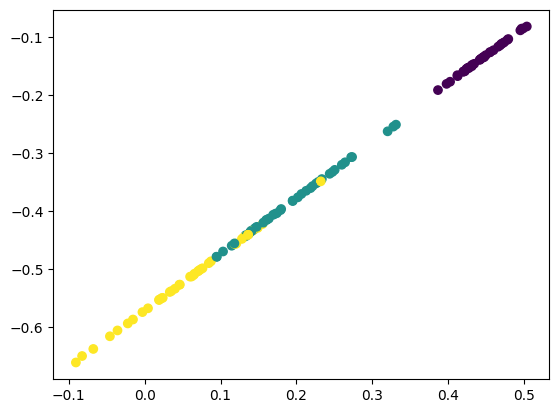

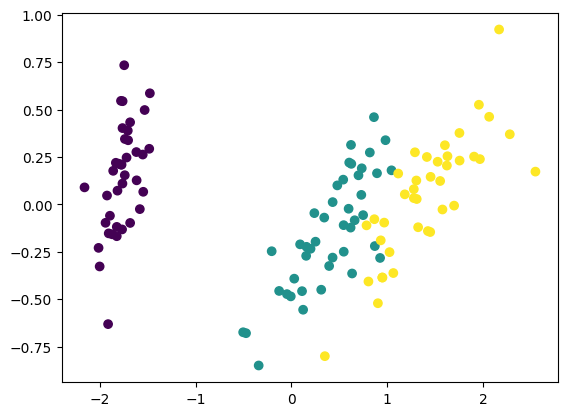

In [ ]:
# plt.scatter(new[:,0], new[:,1], c=y_train)
# plt.figure()
# plt.scatter(x_train[:,0],x_train[:,1], c=y_train)